### Packages

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

### Interpolation of missing months

In [2]:
# import required module
# import os
# assign directory
directory = '/Users/xiangyikong/Desktop/Flu_preprocess/GLEAM_preds'
 
# iterate over files in
# that directory
files_name = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        files_name.append(f)

In [3]:
weeks_1_df = pd.DataFrame()
weeks_2_df = pd.DataFrame()
weeks_3_df = pd.DataFrame()
weeks_4_df = pd.DataFrame()
for i in files_name:
    if i.endswith(".csv"):
        df = pd.read_csv(i)
        # if df['target'] == '1 wk ahead inc flu hosp':
        weeks_1_df = weeks_1_df.append(df[(df['target'] == '1 wk ahead inc flu hosp') & (df['type'] == 'point')])
        weeks_2_df = weeks_2_df.append(df[(df['target'] == '2 wk ahead inc flu hosp') & (df['type'] == 'point')])
        weeks_3_df = weeks_3_df.append(df[(df['target'] == '3 wk ahead inc flu hosp') & (df['type'] == 'point')])
        weeks_4_df = weeks_4_df.append(df[(df['target'] == '4 wk ahead inc flu hosp') & (df['type'] == 'point')])

weeks_1_df = weeks_1_df.drop(['target','type','quantile'],axis = 1)
weeks_2_df = weeks_2_df.drop(['target','type','quantile'],axis = 1)
weeks_3_df = weeks_3_df.drop(['target','type','quantile'],axis = 1)
weeks_4_df = weeks_4_df.drop(['target','type','quantile'],axis = 1)


weeks_1_df = weeks_1_df.sort_values(by=['target_end_date', 'location'])
weeks_2_df = weeks_2_df.sort_values(by=['target_end_date', 'location'])
weeks_3_df = weeks_3_df.sort_values(by=['target_end_date', 'location'])
weeks_4_df = weeks_4_df.sort_values(by=['target_end_date', 'location'])


### Ground truth

In [4]:
dfg = pd.read_csv("/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv")
dfg['date'] = pd.to_datetime(dfg['date'])
dfg_date_filtered = dfg[(dfg['date'] >= '2022-02-05')]
dates_to_fill = dfg_date_filtered['date'].unique()
lst_dates = [str(pd.to_datetime(i).date()) for i in dates_to_fill]

#### After 2021 Jan

<AxesSubplot:xlabel='date'>

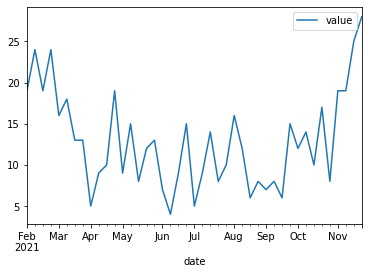

In [5]:
dfg_date_filtered_after_2021_01 = dfg[(dfg['date'] >= '2021-02-01')&(dfg['date'] < '2021-12-01')]
dfg_date_filtered_after_2021_01[dfg_date_filtered_after_2021_01['location'] == '06'][['date','value']].plot(x = 'date',y = 'value')

#### Visualization of California Flu Data

In [46]:
class Flu_Interpolation:
    def __init__(self,Gleam_weekly_forcast_df,ground_truth_df,state):
        self.weeks_df = Gleam_weekly_forcast_df
        self.dfg = ground_truth_df
        self.state = state
        self.first_date = self.weeks_df['target_end_date'].unique()[0]
        self.dfg['date'] = pd.to_datetime(self.dfg['date'])
        self.dfg_date_filtered = self.dfg[(self.dfg['date'] >= self.first_date)]
        dates_to_fill = self.dfg_date_filtered['date'].unique()
        self.lst_dates = [str(pd.to_datetime(i).date()) for i in dates_to_fill]
    def interpolate(self,dates_1,dates_2):
        self.weeks_df_to_fill = self.weeks_df[self.weeks_df['location'] == self.state][['target_end_date','value']]
        for i in self.lst_dates:
            if i not in self.weeks_df_to_fill['target_end_date'].unique():
                self.weeks_df_to_fill = self.weeks_df_to_fill.append({'target_end_date': i, 'value': np.nan}, ignore_index=True)
        self.weeks_df_to_fill.sort_values('target_end_date',inplace = True)
        self.weeks_df_to_fill['target_end_date'] = pd.to_datetime(self.weeks_df_to_fill['target_end_date'])

        self.state_truth = self.dfg_date_filtered[self.dfg_date_filtered['location'] == self.state][['date','value']]
        self.merged_truth_forecast = pd.merge(self.weeks_df_to_fill, self.state_truth, left_on='target_end_date', right_on='date', how='left')

        self.merged_truth_forecast['value_z'] = (self.merged_truth_forecast['value_x'])
        index_1 = self.merged_truth_forecast[self.merged_truth_forecast['target_end_date'] == dates_1].index[0]
        index_2 = self.merged_truth_forecast[self.merged_truth_forecast['target_end_date'] == dates_2].index[0]
        self.merged_truth_forecast.iloc[index_1,4] = self.merged_truth_forecast.iloc[index_1,3]
        self.merged_truth_forecast.iloc[index_2,4] = self.merged_truth_forecast.iloc[index_2,3]
        self.merged_truth_forecast['value_a'] = self.merged_truth_forecast['value_z'].interpolate(method = "pchip", order=2)
        return self.merged_truth_forecast[['target_end_date','value_a']]

    def plot_before_interpolation(self):
        plt.figure(figsize=(20,10))
        ax = self.state_truth.plot(x = 'date',y = 'value',label="Truth")
        ax.set_ylabel('Number of Flu Cases')
        self.weeks_df_to_fill[['target_end_date','value']].plot(ax=ax, x = 'target_end_date',y = 'value',label = 'Gleam Prediction')
        plt.title(self.state)
        plt.show()

    def plot_after_interpolation(self):
        ax = self.state_truth.plot(x = 'date',y = 'value',label="Truth")
        ax.set_ylabel('Number of Flu Cases')
        self.merged_truth_forecast[['target_end_date','value_a']].plot(ax=ax, x = 'target_end_date',y = 'value_a',label = 'Interpolated GLEAM Prediction')
        plt.title(self.state)
        plt.show()

        

In [31]:
weeks_1_df['location'].unique()

array(['01', '02', '04', '05', '06', '08', '09', '10', '12', '13', '15',
       '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
       '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49',
       '50', '51', '53', '54', '55', '56', 'US', '11'], dtype=object)

In [19]:
dfg = pd.read_csv("/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv")
flu_inter = Flu_Interpolation(weeks_1_df,dfg,'12')
after_interpolation = flu_inter.interpolate("2022-07-30","2022-10-01")
# flu_inter.plot_before_interpolation()
# flu_inter.plot_after_interpolation()

#### Interpolate all Week 1 

In [36]:
dfg = pd.read_csv("/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv")
week1_after_interpolation = pd.DataFrame()
for i in weeks_1_df['location'].unique():
    flu_inter = Flu_Interpolation(weeks_1_df,dfg,i)
    interpolated_df = flu_inter.interpolate("2022-07-30","2022-10-01")
    interpolated_df['location'] = i
    week1_after_interpolation = week1_after_interpolation.append(interpolated_df)

/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/3001658042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/3001658042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/3001658042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

#### Interpolate all Week 2

In [54]:
dfg = pd.read_csv("/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv")
week2_after_interpolation = pd.DataFrame()
for i in weeks_2_df['location'].unique():
    flu_inter = Flu_Interpolation(weeks_2_df,dfg,i)
    interpolated_df = flu_inter.interpolate("2022-07-30","2022-10-01")
    interpolated_df['location'] = i
    week2_after_interpolation = week2_after_interpolation.append(interpolated_df)

/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1522516209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1522516209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1522516209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

#### Interpolate all Week 3

In [55]:
dfg = pd.read_csv("/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv")
week3_after_interpolation = pd.DataFrame()
for i in weeks_3_df['location'].unique():
    flu_inter = Flu_Interpolation(weeks_3_df,dfg,i)
    interpolated_df = flu_inter.interpolate("2022-07-30","2022-10-01")
    interpolated_df['location'] = i
    week3_after_interpolation = week3_after_interpolation.append(interpolated_df)

/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1187205681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1187205681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1187205681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

#### Interpolate all Week 4

In [56]:
dfg = pd.read_csv("/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv")
week4_after_interpolation = pd.DataFrame()
for i in weeks_4_df['location'].unique():
    flu_inter = Flu_Interpolation(weeks_4_df,dfg,i)
    interpolated_df = flu_inter.interpolate("2022-07-30","2022-10-01")
    interpolated_df['location'] = i
    week4_after_interpolation = week4_after_interpolation.append(interpolated_df)

/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1948877233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1948877233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['location'] = i
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_61000/1948877233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
week1_after_interpolation.to_csv("week1_after_interpolation.csv",index = False)
week2_after_interpolation.to_csv("week2_after_interpolation.csv",index = False)
week3_after_interpolation.to_csv("week3_after_interpolation.csv",index = False)
week4_after_interpolation.to_csv("week4_after_interpolation.csv",index = False)

#### Tsprial -- 18weeks of missing

In [96]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from tsprial.forecasting import ForecastingCascade

In [109]:
temp_1 = dfg[(dfg['date'] >= '2021-07-02')&(dfg['date'] < '2021-10-31')]
temp_1[temp_1['location'] == '06']

,date,location,location_name,value
3750,2021-07-03,06,California,5
3804,2021-07-10,06,California,9
3858,2021-07-17,06,California,14
3912,2021-07-24,06,California,8
3966,2021-07-31,06,California,10
4020,2021-08-07,06,California,16
4074,2021-08-14,06,California,12
4128,2021-08-21,06,California,6
4182,2021-08-28,06,California,8
4236,2021-09-04,06,California,7


In [110]:
temp_2 = dfg[(dfg['date'] >= '2022-07-02')&(dfg['date'] < '2022-10-31')]
temp_2[temp_2['location'] == '06']

,date,location,location_name,value
6558,2022-07-02,06,California,192
6612,2022-07-09,06,California,122
6666,2022-07-16,06,California,102
6720,2022-07-23,06,California,64
6774,2022-07-30,06,California,46
6828,2022-08-06,06,California,39
6882,2022-08-13,06,California,38
6936,2022-08-20,06,California,39
6990,2022-08-27,06,California,33
7044,2022-09-03,06,California,35


In [162]:
np.array(temp_2[temp_2['location'] == '06']['date'])

array(['2022-07-02T00:00:00.000000000', '2022-07-09T00:00:00.000000000',
       '2022-07-16T00:00:00.000000000', '2022-07-23T00:00:00.000000000',
       '2022-07-30T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-09-03T00:00:00.000000000',
       '2022-09-10T00:00:00.000000000', '2022-09-17T00:00:00.000000000',
       '2022-09-24T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-10-08T00:00:00.000000000', '2022-10-15T00:00:00.000000000',
       '2022-10-22T00:00:00.000000000', '2022-10-29T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [143]:
dfg_date_filtered_after_2021_01 = dfg[(dfg['date'] >= '2021-02-01')&(dfg['date'] < '2022-02-01')]
train_1 = np.array(dfg_date_filtered_after_2021_01[dfg_date_filtered_after_2021_01['location'] == '06']['value'])

In [150]:
train_1

array([ 19,  24,  19,  24,  16,  18,  13,  13,   5,   9,  10,  19,   9,
        15,   8,  12,  13,   7,   4,   9,  15,   5,   9,  14,   8,  10,
        16,  12,   6,   8,   7,   8,   6,  15,  12,  14,  10,  17,   8,
        19,  19,  25,  28,  54,  66,  70, 118,  97,  93,  81,  64,  30])

In [158]:
train_2 = np.array(weeks_1_df_to_fill['value'])

In [186]:
len(train_2)

41

In [209]:
from sklearn.impute import KNNImputer

In [210]:
imputer = KNNImputer(n_neighbors=2)

In [212]:
df_filled = imputer.fit_transform(weeks_1_df_to_fill[['value']])

In [213]:
df_filled

array([[ 37.07582898],
       [ 38.12074836],
       [ 34.64070487],
       [ 19.12381089],
       [ 22.25877379],
       [ 24.80417555],
       [ 32.57508131],
       [ 36.78207051],
       [ 68.16065005],
       [ 77.84018066],
       [104.11068535],
       [115.79261344],
       [142.35002574],
       [178.15044077],
       [194.37979607],
       [271.56443195],
       [292.41081812],
       [289.06148906],
       [155.5186761 ],
       [312.3616369 ],
       [303.28204823],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [155.5186761 ],
       [242.86700056],
       [583.69786313]])